# Demonstration of Bayesian QNM Fits

This is a tutorial / demonstration of the main functions used in this code. 

## Basic likelihood (amplitudes only) 

In [1]:
import qnmfits 
import numpy as np
import likelihood_funcs
import CCE 
import scipy
import corner

We start by importing a simulation (as a qnmfits.Custom object). We obtain the remnant mass and spin (which we denote with _0 in code and as a subscript * in the written notes). We also choose a start time for the fit, and modes to include in the model.  

In [2]:
sim = CCE.SXS_CCE("0001")

data_times = sim.times
data = sim.h

chif_mag_0 = sim.chif_mag
Mf_0 = sim.Mf

qnm_list = [(2,2,0,1), (2,2,1,1), (3,2,0,1), (3,2,1,1)]
spherical_modes = [(2,2), (3,2)]

t0 = 20

sigma = 1e-4

Next, we determine the least squared amplitudes. The C_0 list can be used when we include Mf and/or Chif as parameters (otherwise it isn't needed). We hereafter treat the real and imaginary QNM amplitude as separate parameters, included in sequence in the true_params list. 

In [3]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=100,
    spherical_modes=spherical_modes,
)

C_0 = ls_fit['C']

true_params = []
for re_c, im_c in zip(np.real(ls_fit['C']), np.imag(ls_fit['C'])):
    true_params.append(re_c)
    true_params.append(im_c)

We now construct the fisher matrix and 'b_vector' (the inner product of  model elements and data). For now, we use a constant numerical noise set to sigma (i.e. the inverse of the noise covariance is the identity matrix / sigma**2). 

In [4]:
fisher_matrix = likelihood_funcs.get_fisher_matrix(qnm_list, spherical_modes, t0, data_times, Mf_0, chif_mag_0, inv_cov=sigma)  
b_vec = likelihood_funcs.get_b_vector(qnm_list, spherical_modes, t0, data_times, data, Mf_0, chif_mag_0, inv_cov=sigma)

Precomputation time:  0.010055065155029297
Fisher matrix computation time:  0.0007238388061523438


We now compute the covariance matrix and mean vector. 

In [5]:
mean_vector = np.linalg.solve(fisher_matrix, b_vec)
covariance_matrix = np.linalg.inv(fisher_matrix)

As a quick check, we can compare the mean vector to the least squares values.  

In [6]:
print("Mean vector: ", list(mean_vector))
print("Least squares amplitudes :", true_params)
print("Similar?", np.allclose(mean_vector, true_params, rtol=1e-2))

Mean vector:  [0.05000173787484515, 0.1711862290107576, 0.01822529763132035, -0.014175302198079848, 0.004859511857940257, 0.002707136098212088, 0.00021214633128046047, -0.0010034289490793533]
Least squares amplitudes : [0.04999498008327843, 0.17118601661192326, 0.01824576942307358, -0.0141760953067477, 0.00486003091433753, 0.0027069114229464892, 0.00021066388117355322, -0.001002205201381146]
Similar? True


Now we take some samples from a multivariate normal and plot these. 

In [7]:
samples = scipy.stats.multivariate_normal(mean_vector, covariance_matrix, allow_singular=True).rvs(size=10000)

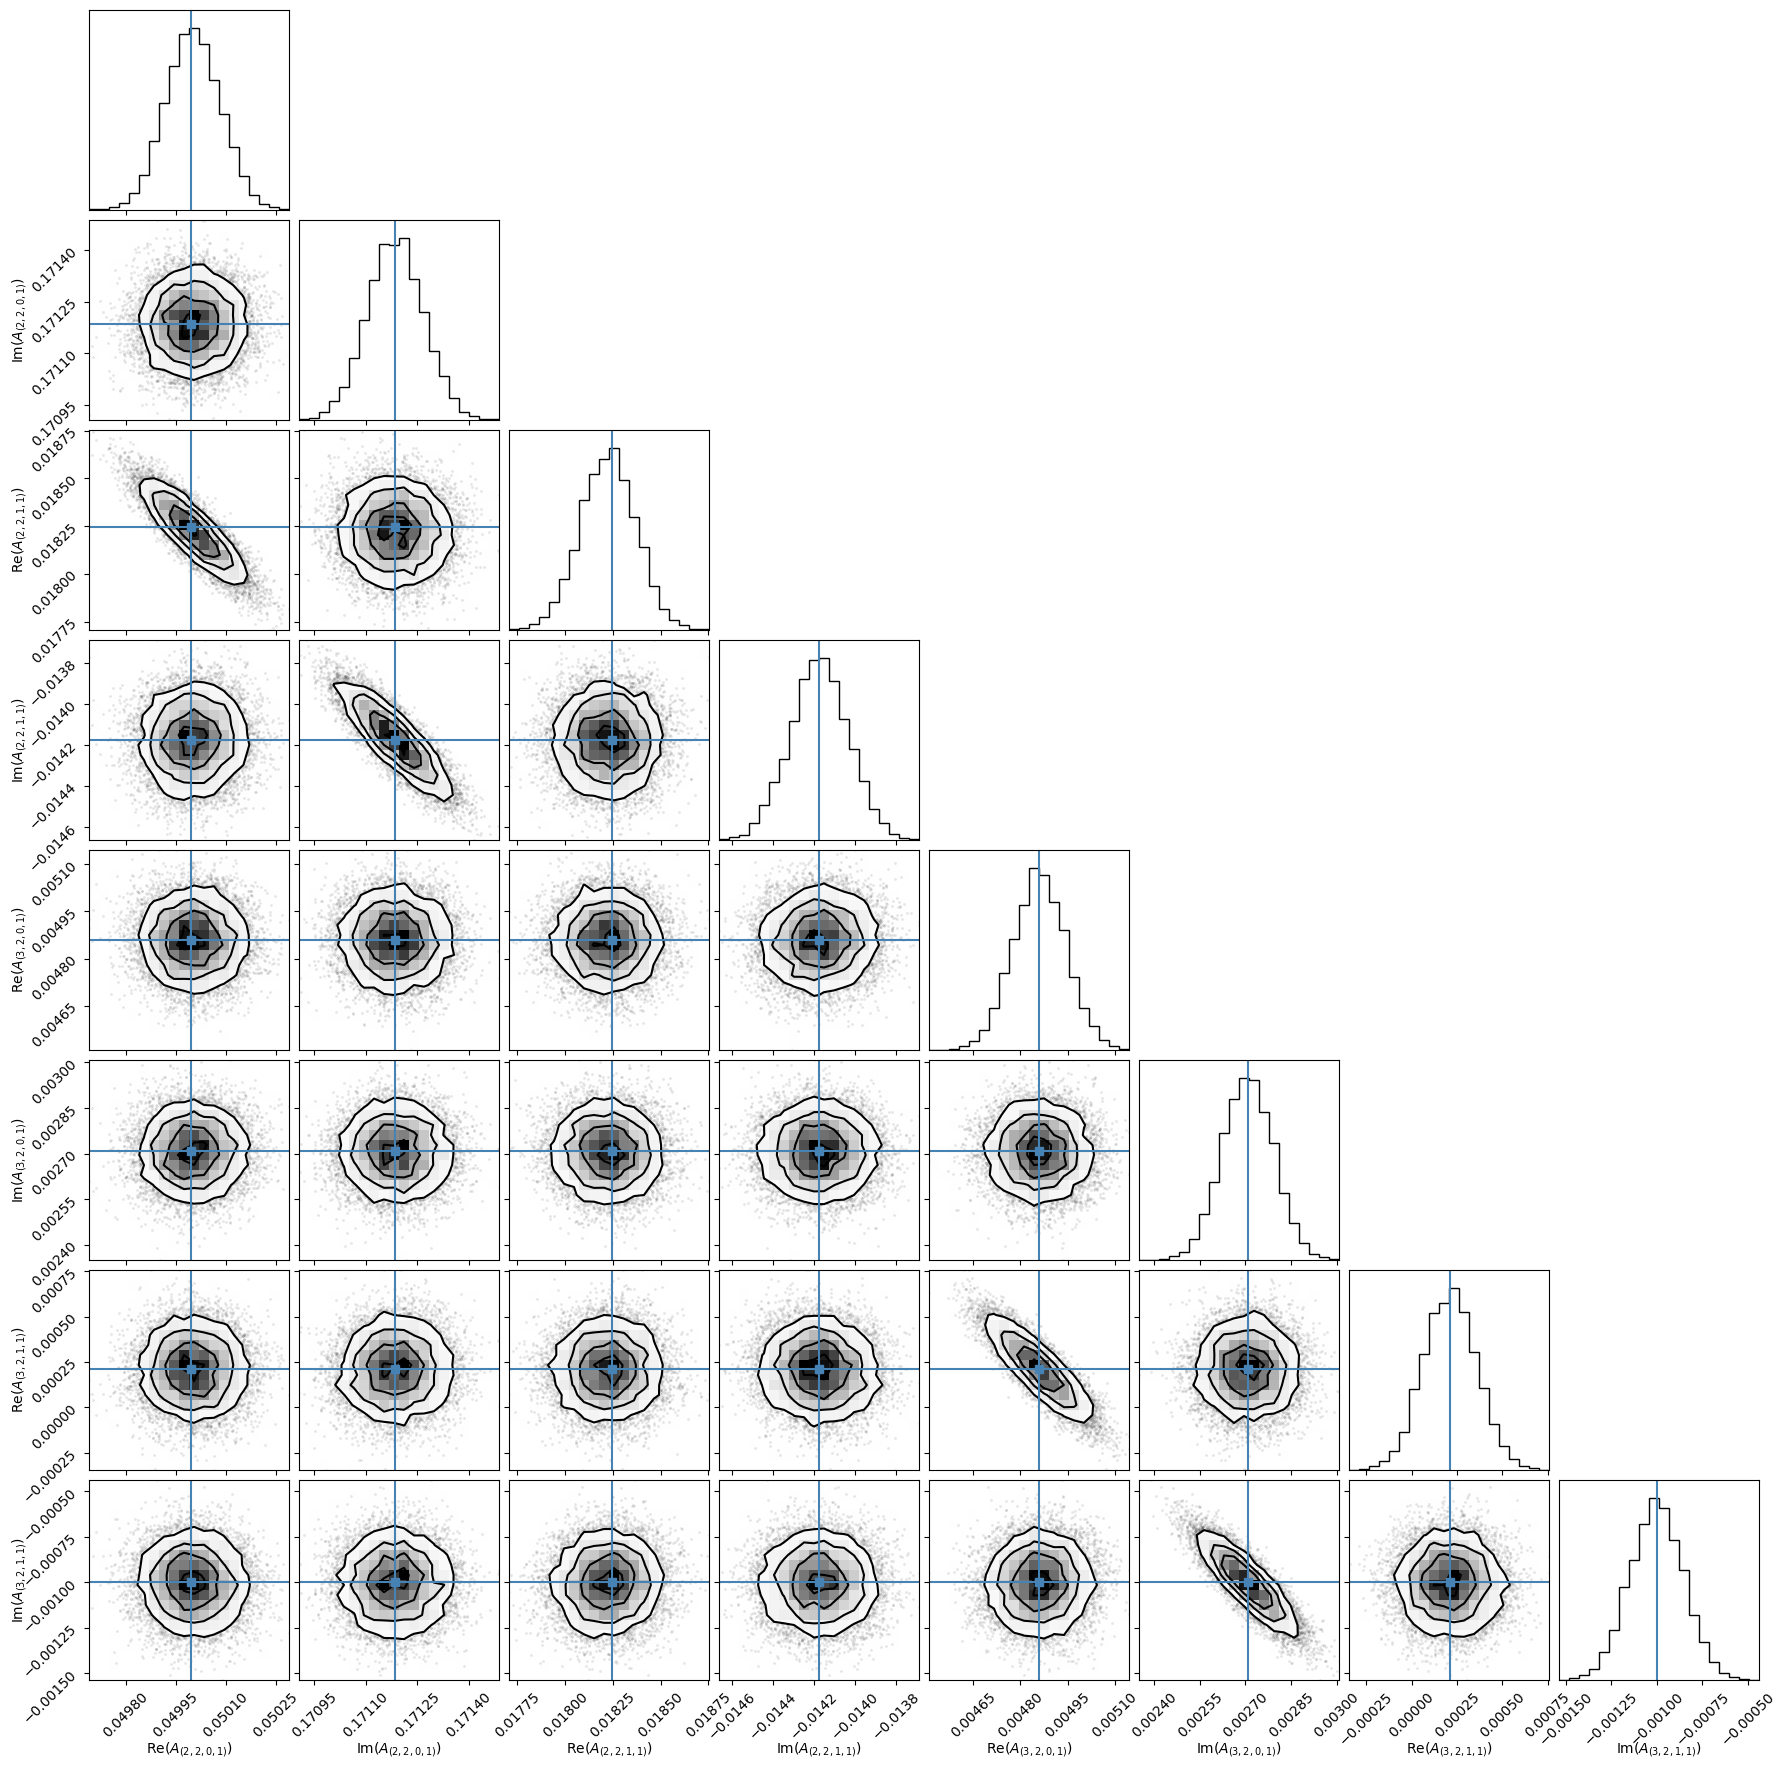

In [8]:
labels = [r'$\mathrm{Re}(A_{(2,2,0,1)})$', 
          r'$\mathrm{Im}(A_{(2,2,0,1)})$', 
          r'$\mathrm{Re}(A_{(2,2,1,1)})$', 
          r'$\mathrm{Im}(A_{(2,2,1,1)})$', 
          r'$\mathrm{Re}(A_{(3,2,0,1)})$', 
          r'$\mathrm{Im}(A_{(3,2,0,1)})$',
          r'$\mathrm{Re}(A_{(3,2,1,1)})$', 
          r'$\mathrm{Im}(A_{(3,2,1,1)})$'
          ]

_ = corner.corner(
    samples,
    truths=true_params,
    labels=labels,
    )

## Basic likelihood (mass and spin included) 

We can also include the mass and spin as parameters in the model. In practise they are included as the final two elements in parameter lists:

$[\rm Re(A_1), \rm Im(A_1), \rm Re(A_2), \rm Im(A_2), \dots, \chi_f, M_f]$.

To include these, set the appropriate boolean arguments in get_fisher_matrix, get_b_vector. C_0 also needs to be set to the the list obtained from the least-squares fit, and the true_param values need to be added to the mean vector.  The reason for avoiding these in the amplitude-only case is to save us having to compute the least-squares fit (because, in this case, only $M_*$ and $\chi_*$ are needed). 


In [9]:
true_params_full = true_params + [chif_mag_0, Mf_0]

In [10]:
fisher_matrix = likelihood_funcs.get_fisher_matrix(qnm_list, spherical_modes, t0, data_times, Mf_0, chif_mag_0, inv_cov=sigma, C_0=C_0, include_chif=True, include_Mf=True)  
b_vec = likelihood_funcs.get_b_vector(qnm_list, spherical_modes, t0, data_times, data, Mf_0, chif_mag_0, inv_cov=sigma, C_0=C_0, include_chif=True, include_Mf=True)

Precomputation time:  0.005384206771850586
Fisher matrix computation time:  0.0017883777618408203
Note that the mean vector is now cov_matrix @ b PLUS theta_0 (the true parameter values)


In [11]:
mean_vector = np.linalg.solve(fisher_matrix, b_vec) + true_params_full
covariance_matrix = np.linalg.inv(fisher_matrix)

Note that we no longer expect the mean vector to precisely return the least squares values. 

In [12]:
print("Mean vector: ", list(mean_vector))
print("Least squares parameters :", true_params_full)
print("Similar?", np.allclose(mean_vector, true_params_full, rtol=1e-1))

Mean vector:  [0.05051635679228944, 0.17110190600353262, 0.017606116968153094, -0.014067824840356416, 0.0048607816941778305, 0.0026976877178009756, 0.00021008796858274875, -0.0009878304086924983, 0.6859246635107714, 0.951564759917536]
Least squares parameters : [0.04999498008327843, 0.17118601661192326, 0.01824576942307358, -0.0141760953067477, 0.00486003091433753, 0.0027069114229464892, 0.00021066388117355322, -0.001002205201381146, 0.686441921316848, 0.9516192579333816]
Similar? True


In [13]:
samples = scipy.stats.multivariate_normal(mean_vector, covariance_matrix, allow_singular=True).rvs(size=10000)

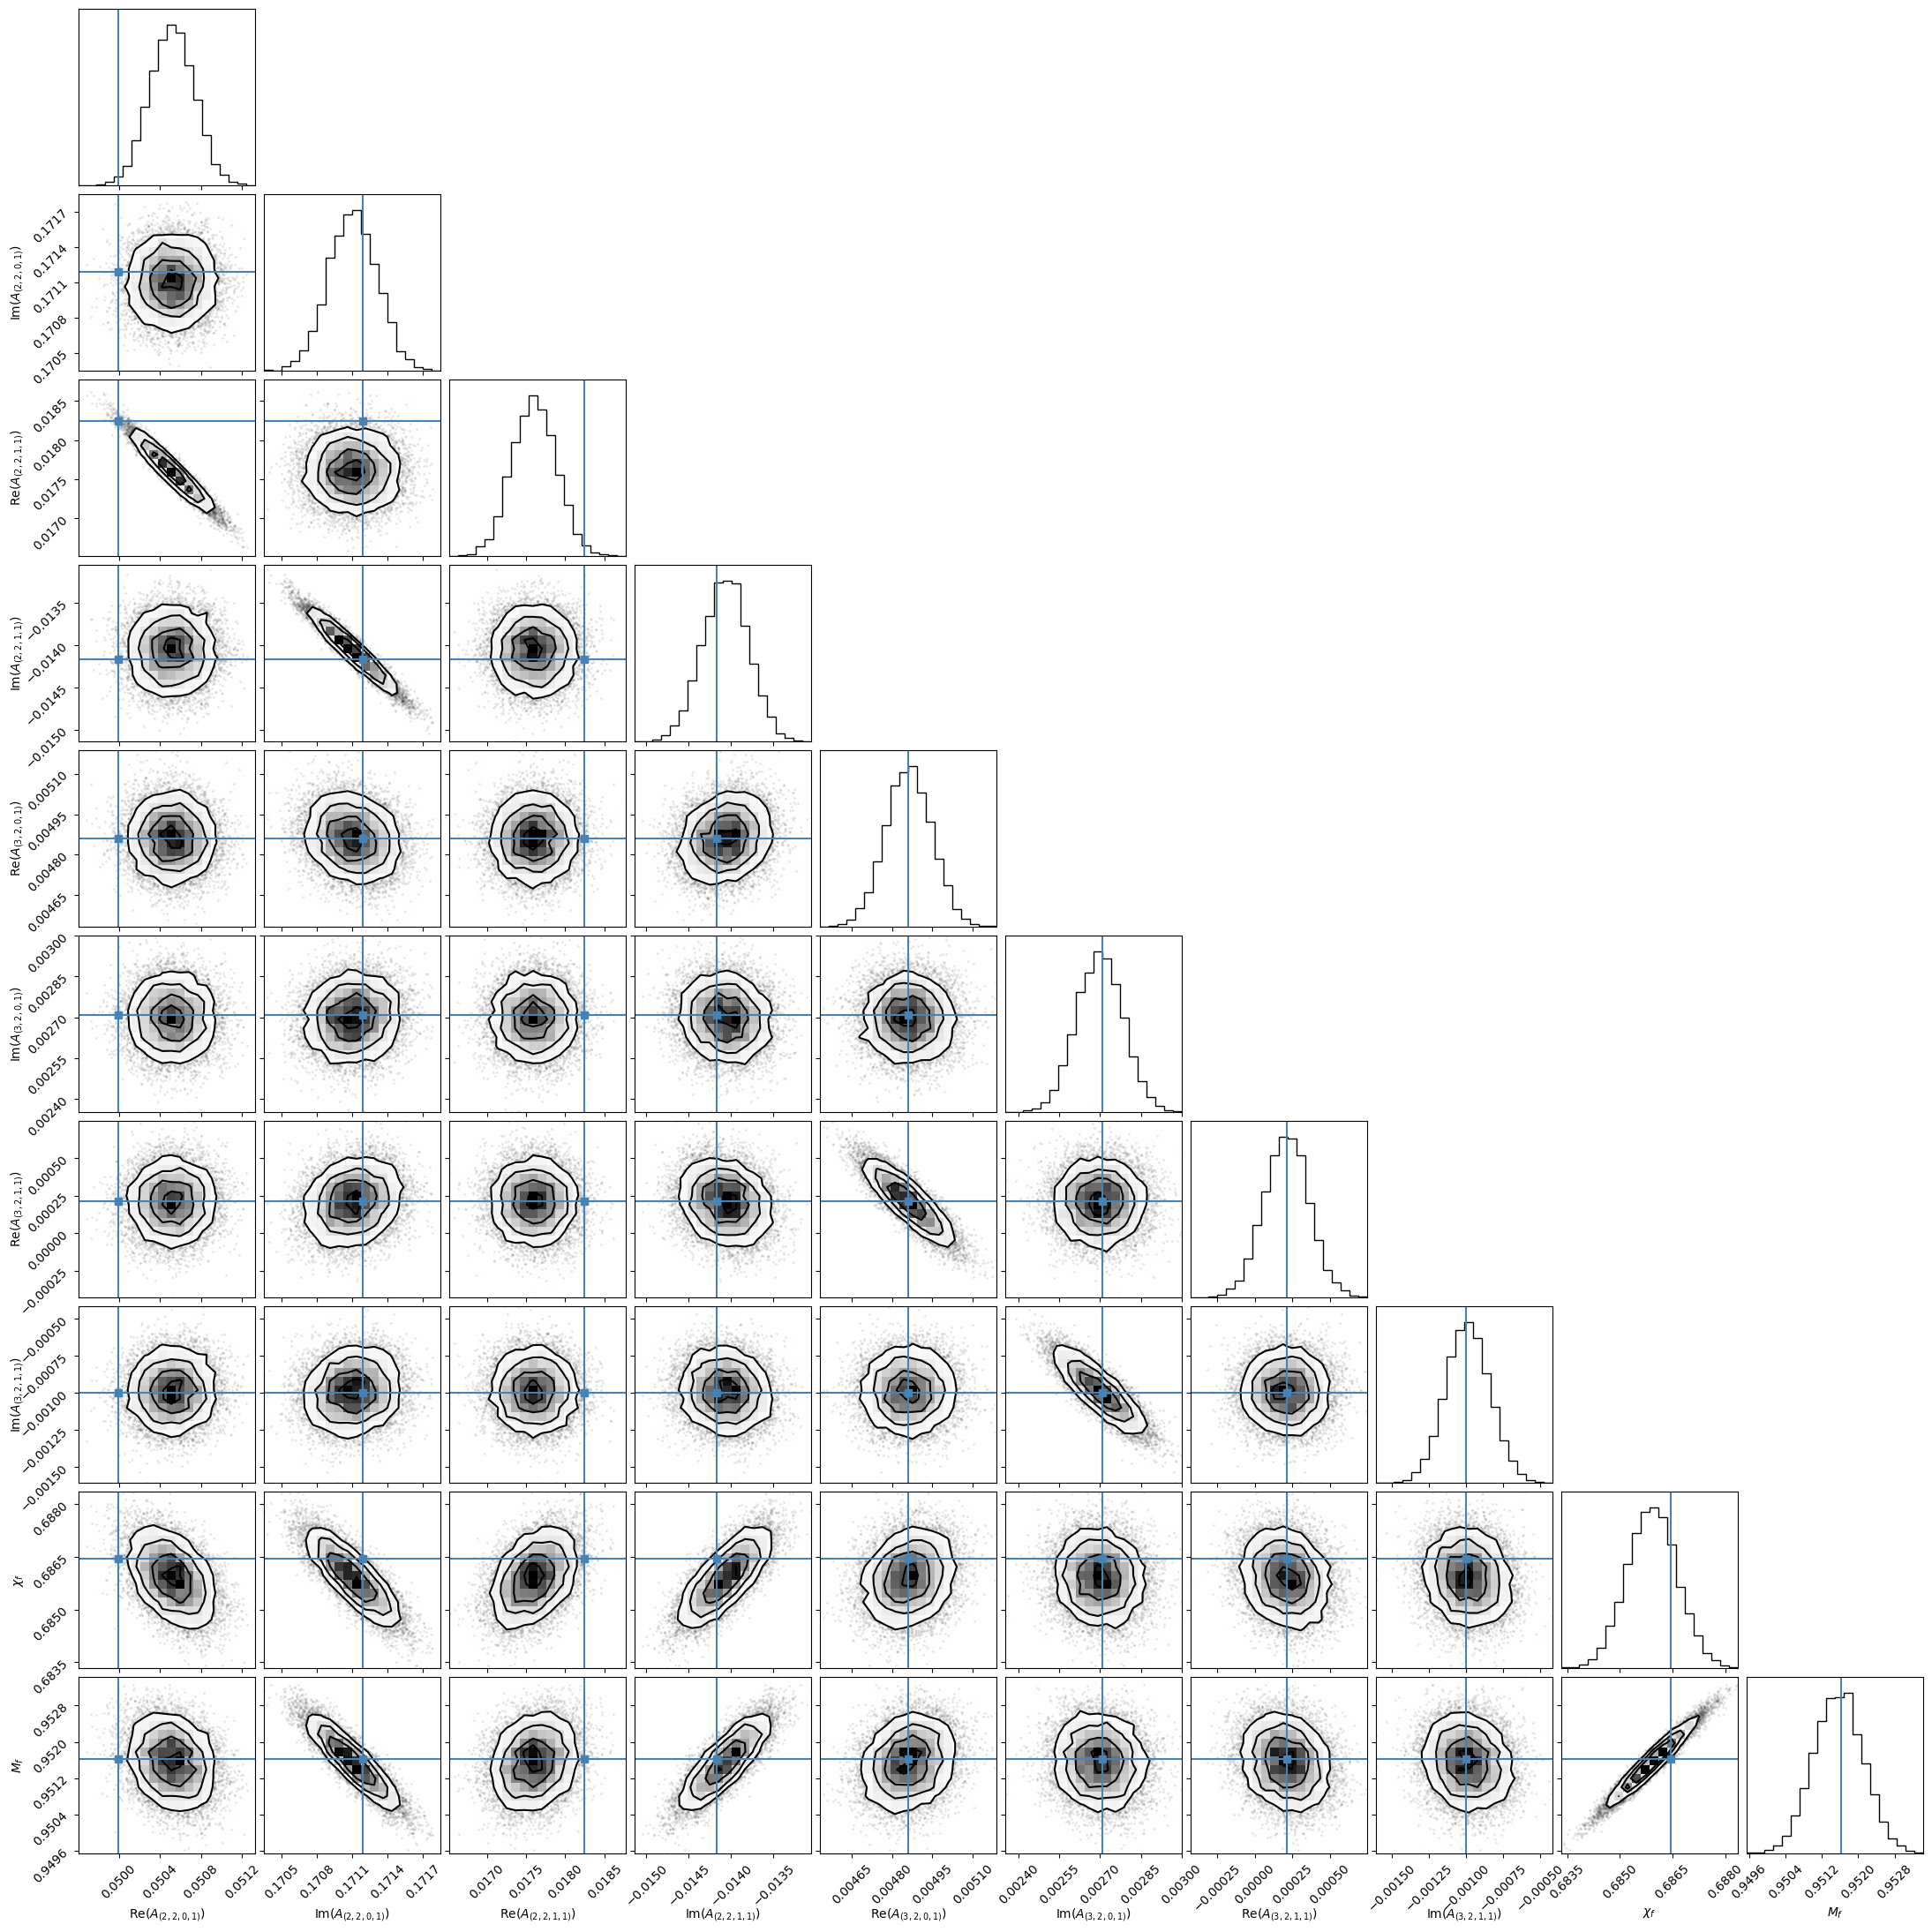

In [14]:
labels = [r'$\mathrm{Re}(A_{(2,2,0,1)})$', 
          r'$\mathrm{Im}(A_{(2,2,0,1)})$', 
          r'$\mathrm{Re}(A_{(2,2,1,1)})$', 
          r'$\mathrm{Im}(A_{(2,2,1,1)})$', 
          r'$\mathrm{Re}(A_{(3,2,0,1)})$', 
          r'$\mathrm{Im}(A_{(3,2,0,1)})$',
          r'$\mathrm{Re}(A_{(3,2,1,1)})$', 
          r'$\mathrm{Im}(A_{(3,2,1,1)})$',
          r'$\chi_f$',
          r'$M_f$'
          ]

_ = corner.corner(
    samples,
    truths=true_params_full,
    labels=labels,
    )

## Marginalisation 

Finally, we can marginalise over, for example, the amplitudes, to leave us with values for the mass and spin. Note that the marginalise function takes a parameter list as an argument rather than a qnm list. This is each QNM repeated twice, followed by "chif" and "Mf" as required.  

In [15]:
parameters = [qnm for qnm in qnm_list for _ in range(2)] + ["chif", "Mf"] 
parameter_choice = ["chif", "Mf"]
param_vals = [chif_mag_0, Mf_0]

marginal_mean, marginal_fisher = likelihood_funcs.marginalise(parameter_choice, parameters, mean_vector, fisher_matrix)
marginal_covariance = np.linalg.inv(marginal_fisher)

In [16]:
print(parameters)

[(2, 2, 0, 1), (2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 1, 1), (3, 2, 0, 1), (3, 2, 0, 1), (3, 2, 1, 1), (3, 2, 1, 1), 'chif', 'Mf']


In [17]:
samples = scipy.stats.multivariate_normal(marginal_mean, marginal_covariance, allow_singular=True).rvs(size=10000)

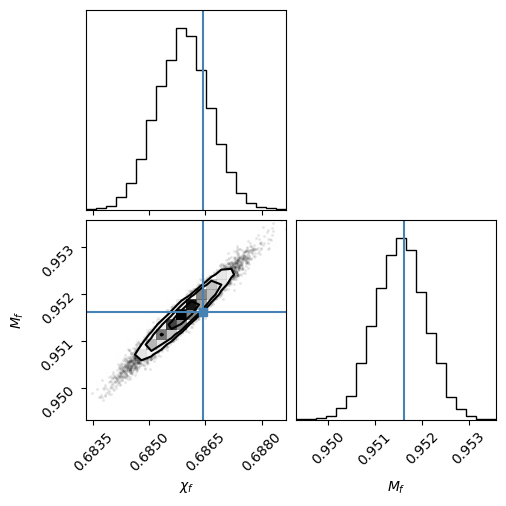

In [18]:
labels = [r'$\chi_f$', r'$M_f$']

_ = corner.corner(
    samples,
    truths=param_vals,
    labels=labels,
    )

## Numerical error

TODO: include gaussian process kernel example. 